<a href="https://colab.research.google.com/github/AdamVinestock/Recommendation-Systems-RecSys-2022/blob/main/Recsys2022_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import pandas as pd
import numpy as np
import os.path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Maybe add training data through google drive?
# from google.colab import drive
# drive.mount('/content/drive')
# file_path = '/content/drive/My Drive/path_to_your_folder/your_file.csv'
# train_sessions = pd.read_csv(file_path)

In [135]:
# URL of the raw CSV file in the GitHub repository
candidate_items_url = "https://raw.githubusercontent.com/AdamVinestock/Recommendation-Systems-RecSys-2022/main/dataset/candidate_items.csv"
item_features_url = "https://raw.githubusercontent.com/AdamVinestock/Recommendation-Systems-RecSys-2022/main/dataset/item_features.csv"
test_full_sessions_url = "https://raw.githubusercontent.com/AdamVinestock/Recommendation-Systems-RecSys-2022/main/dataset/test_full_sessions.csv"
test_full_purchases_url = "https://raw.githubusercontent.com/AdamVinestock/Recommendation-Systems-RecSys-2022/main/dataset/test_full_purchases.csv"

# Reading the CSV files into a DataFrame, Training session and purchases are too large for github Repo!@!@!
candidate_items = pd.read_csv(candidate_items_url)
item_features = pd.read_csv(item_features_url)
test_full_sessions = pd.read_csv(test_full_sessions_url)
test_full_purchases = pd.read_csv(test_full_purchases_url)

train_sessions = pd.read_csv("/content/train_sessions.csv")
train_purchases = pd.read_csv("/content/train_purchases.csv")

print("Candidate items")
print(candidate_items.head())
print("-----------------------------------------")
print("Item features")
print(item_features.head())
print("-----------------------------------------")
print("train_sessions")
print(train_sessions.head())
print("-----------------------------------------")
print("train_purchases")
print(train_purchases.head())
print("-----------------------------------------")
print("test_full_sessions")
print(test_full_sessions.head())
print("-----------------------------------------")
print("test_full_purchases")
print(test_full_purchases.head())

Candidate items
   item_id
0        4
1        8
2        9
3       19
4       20
-----------------------------------------
Item features
   item_id  feature_category_id  feature_value_id
0        2                   56               365
1        2                   62               801
2        2                   68               351
3        2                   33               802
4        2                   72                75
-----------------------------------------
train_sessions
   session_id  item_id                     date
0           3     9655  2020-12-18 21:25:00.373
1           3     9655  2020-12-18 21:19:48.093
2          13    15654  2020-03-13 19:35:27.136
3          18    18316  2020-08-26 19:18:30.833
4          18     2507  2020-08-26 19:16:31.211
-----------------------------------------
train_purchases
   session_id  item_id                     date
0           3    15085  2020-12-18 21:26:47.986
1          13    18626  2020-03-13 19:36:15.507
2          18  

In [136]:
# Checking from duplicates in candidate items
len(candidate_items['item_id'])-len(candidate_items['item_id'].drop_duplicates())

0

In [162]:
# number of train and test sessions
n_train_sessions = len(train_purchases)
n_test_sessions = len(test_full_purchases)
print(f"Number of training sessions: {n_train_sessions} (1 million)")
print(f"Number of test sessions: {n_test_sessions} (100k)")

# Checking for items in training set vs test set
train_items = pd.concat([train_sessions["item_id"], train_purchases["item_id"]]).unique()
test_items = pd.concat([test_full_sessions["item_id"], test_full_purchases["item_id"]]).unique()
test_purchased_items = test_full_purchases["item_id"].unique()
unique_candidate_items = candidate_items["item_id"].unique()

count_unique_test_items = len(set(test_items) - set(train_items))
count_unique_train_items = len(set(train_items) - set(test_items))
count_unique_purchased_test = len(set(test_purchased_items) - set(train_items))
count_unique_candidate = len(set(unique_candidate_items) - set(train_items))

print(f"items in test but not in training : {count_unique_test_items}")
print(f"items in test purchases but not in train : {count_unique_purchased_test}")
print(f"items in training but not in test : {count_unique_train_items}")
print(f"items in candidates but not in train : {count_unique_candidate}")

Number of training sessions: 1000000 (1 million)
Number of test sessions: 100000 (100k)
items in test but not in training : 73
items in test purchases but not in train : 62
items in training but not in test : 17544
items in candidates but not in train : 62


In [138]:
df_all = pd.concat((train_sessions, train_purchases, test_full_sessions, test_full_purchases), axis=0)

In [139]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6439812 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   session_id  int64 
 1   item_id     int64 
 2   date        object
dtypes: int64(2), object(1)
memory usage: 196.5+ MB


In [140]:
# Checking for NaN's
df_all.isna().sum()

session_id    0
item_id       0
date          0
dtype: int64

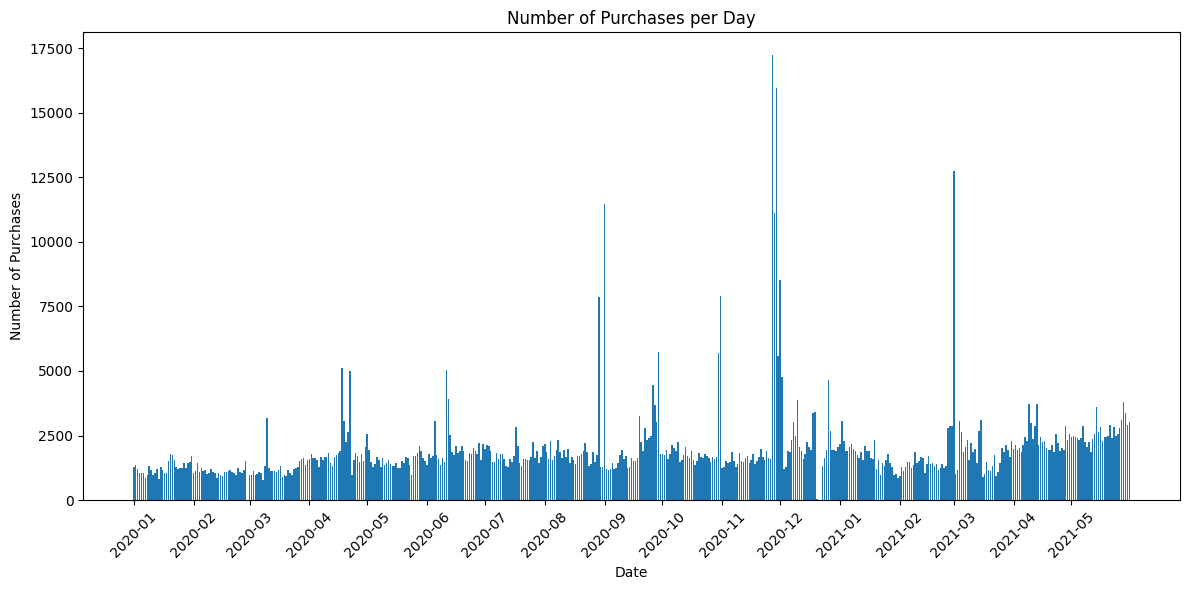

Dates exceeding 7500 purchases: 
0    2020-08-29
1    2020-09-01
2    2020-10-31
3    2020-11-27
4    2020-11-28
5    2020-11-29
6    2020-12-01
7    2021-03-01
Name: Date, dtype: object


In [153]:
# Purchases per day Analysis
train_purchases['date'] = pd.to_datetime(train_purchases['date'])
train_purchases['purchase_date'] = train_purchases['date'].dt.date
purchases_per_day = train_purchases.groupby('purchase_date').size()

plt.figure(figsize=(12,6))
plt.bar(purchases_per_day.index, purchases_per_day.values)
plt.title("Number of Purchases per Day")
plt.xlabel("Date")
plt.ylabel("Number of Purchases")

months = train_purchases['date'].dt.to_period('M').unique()
# plt.xticks(filtered_df['Date'], rotation=45)
plt.xticks(months.to_timestamp(), [month.strftime('%Y-%m') for month in months], rotation=45)
plt.tight_layout()
plt.show()

threshold = 7500
dates_above_threshold = purchases_per_day[purchases_per_day > threshold]
filtered_data = purchases_per_day[purchases_per_day > threshold]
filtered_df = pd.DataFrame({'Date': filtered_data.index, 'Purchases': filtered_data.values})
print(f"Dates exceeding {threshold} purchases: \n{filtered_df['Date']}")

In [154]:
# Session Time Analysis - Creating df holding session with purchases for session and purchase
train_purchases.drop(['purchase_date'], axis = 1, inplace=True)
train_df = pd.concat((train_sessions, train_purchases), axis=0)

# Last session id is the purchase
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.sort_values(by=['session_id', 'date'], ascending=[True, True], inplace=True)
train_df['time_diff'] = train_df.groupby('session_id')['date'].diff().dt.total_seconds()

In [143]:
mean_session_length = train_df.groupby('session_id').size().mean() # before removing NaN's

# Drop the NaN values (which occur for the first item in each group)
train_df.dropna(subset=['time_diff'], inplace=True)

# Calculate the descriptive statistics
mean_time_diff = train_df['time_diff'].mean()
median_time_diff = train_df['time_diff'].median()
min_time_diff = train_df['time_diff'].min()
max_time_diff = train_df['time_diff'].max()
mean_time_purchase_last_seen = train_df.groupby('session_id')['time_diff'].last().mean()

print(f"Mean Session views including purchase: {mean_session_length}")
print(f"Mean Time Difference: {mean_time_diff} seconds")
print(f"Median Time Difference: {median_time_diff} seconds")
print(f"Min Time Difference: {min_time_diff} seconds")
print(f"Max Time Difference: {max_time_diff} seconds")
print(f"Mean time between purchase to last seen item: {mean_time_purchase_last_seen} seconds")

sessions_with_long_breaks = train_df.groupby('session_id')['time_diff'].apply(lambda x: (x > 1800).any())
num_sessions_with_long_breaks = sessions_with_long_breaks.sum()
total_sessions = train_df['session_id'].nunique()
split_session_ratio = num_sessions_with_long_breaks / total_sessions
print(f"Ratio of split sessions: {split_session_ratio:3f}")

Mean Session views including purchase: 5.74382
Mean Time Difference: 658.5207492874941 seconds
Median Time Difference: 47.79 seconds
Min Time Difference: 0.0 seconds
Max Time Difference: 85551.211 seconds
Mean time between purchase to last seen item: 873.7611115989996 seconds
Ratio of split sessions: 0.162253


Number of unique feature categories: 73
Number of unique feature values: 890


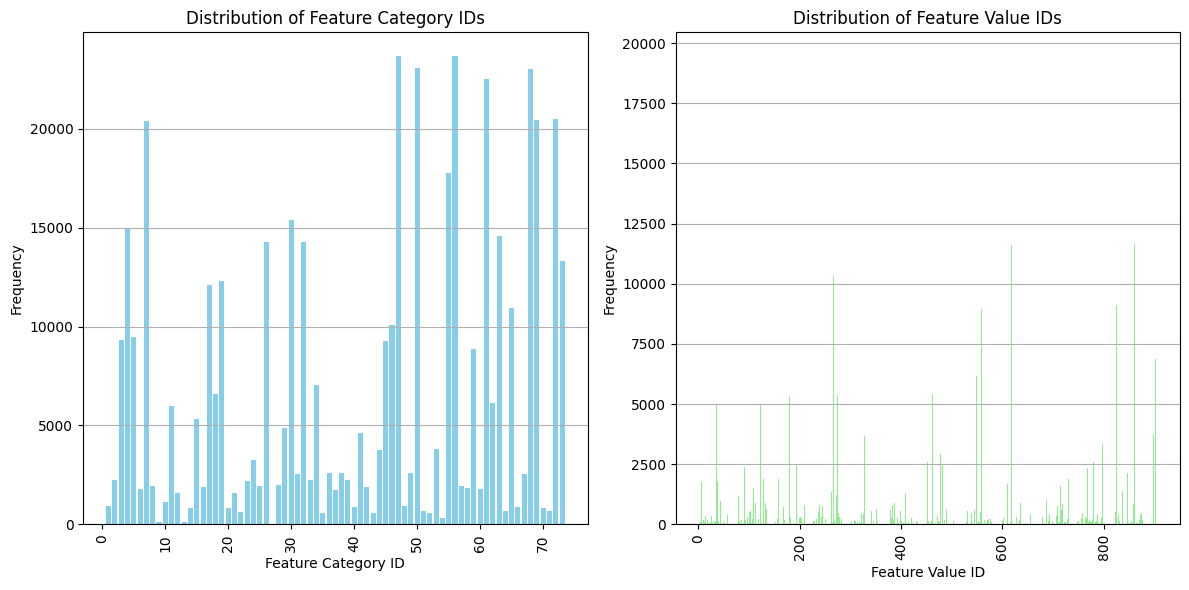

In [144]:
# Analysis of item features
feature_cat_count = item_features.groupby('feature_category_id').size()
feature_val_count = item_features.groupby('feature_value_id').size()

print(f"Number of unique feature categories: {feature_cat_count.shape[0]}")
print(f"Number of unique feature values: {feature_val_count.shape[0]}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].bar(feature_cat_count.index, feature_cat_count.values, color='skyblue')
axes[0].set_title('Distribution of Feature Category IDs')
axes[0].set_xlabel('Feature Category ID')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y')

axes[1].bar(feature_val_count.index, feature_val_count.values, color='lightgreen')
axes[1].set_title('Distribution of Feature Value IDs')
axes[1].set_xlabel('Feature Value ID')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

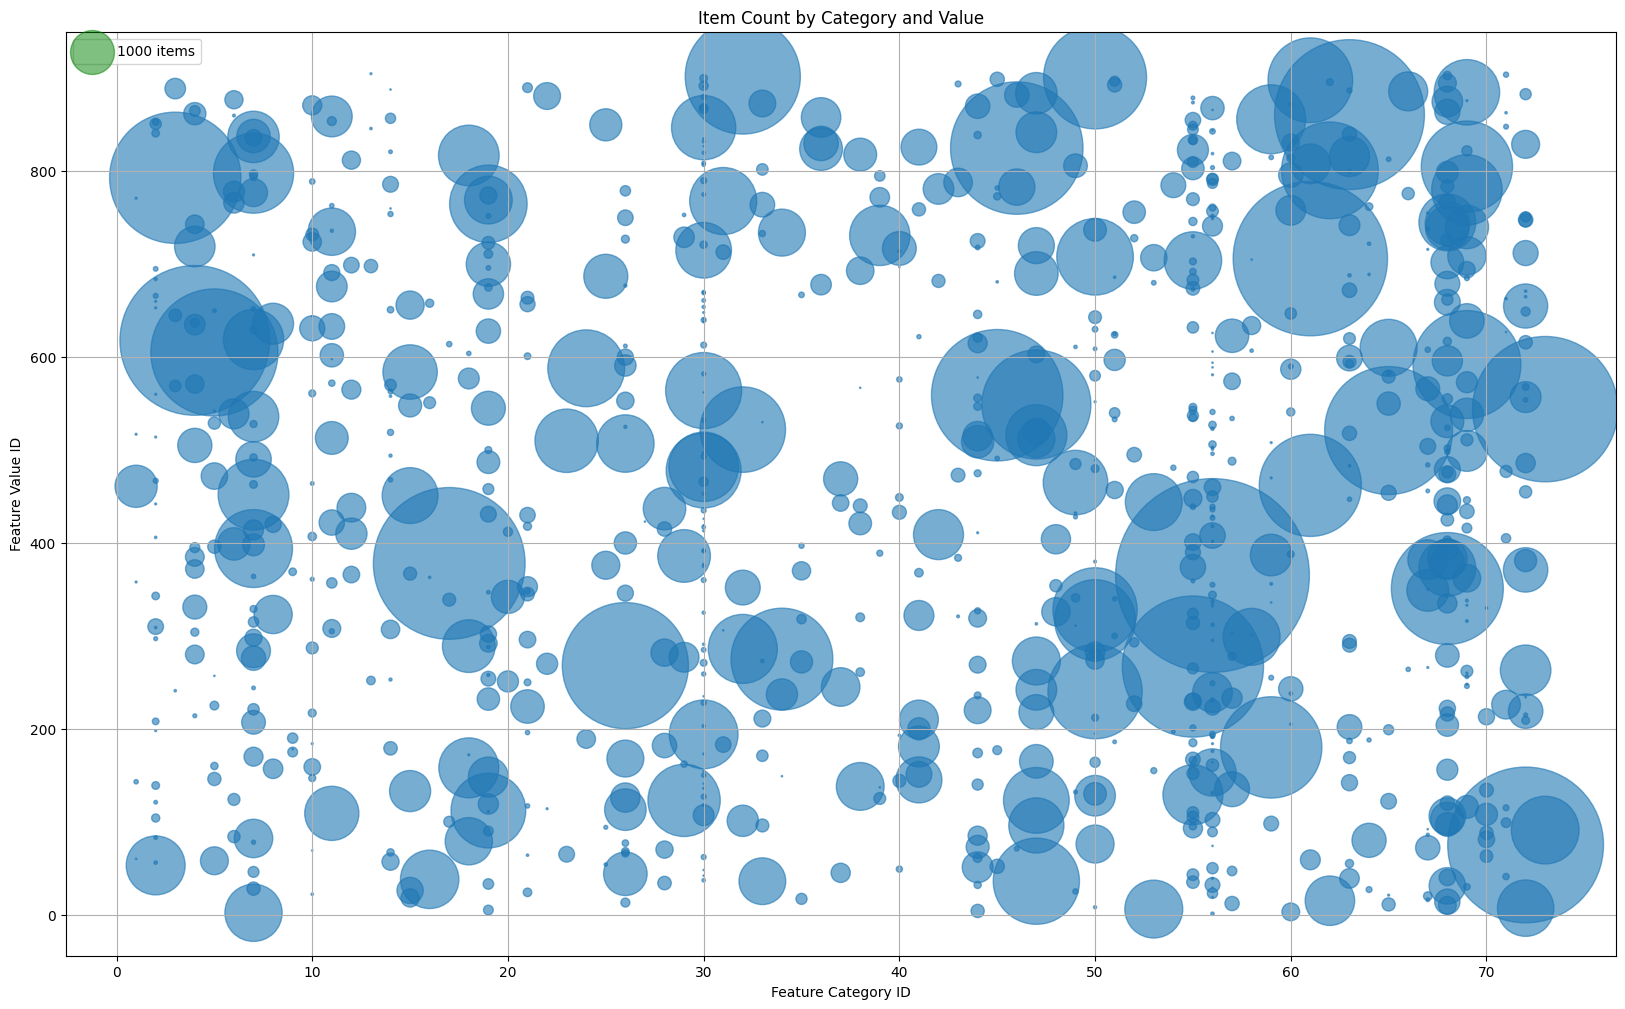

In [156]:
category_value_counts = item_features.groupby(['feature_category_id', 'feature_value_id']).size().reset_index()

plt.figure(figsize=(20, 12))
scatter = plt.scatter(category_value_counts['feature_category_id'], category_value_counts['feature_value_id'], s=category_value_counts[0], alpha=0.6)

avg_size = 1000
plt.scatter([], [], s=avg_size, label='1000 items', alpha=0.5, color='green')
plt.legend(loc='upper left')

plt.title('Item Count by Category and Value')
plt.xlabel('Feature Category ID')
plt.ylabel('Feature Value ID')
plt.grid(True)
plt.show()

In [150]:
# Getting a sense of feature_value set size for sufficiently large item subgroup
random.seed(42)
category_value_counts = item_features.groupby(['feature_category_id', 'feature_value_id'])['item_id'].nunique()

percentile_random = 0
selected_category_value_set = set()
total_items = category_value_counts.sum()
while percentile_random < 0.10:
  random_index = random.randint(0, len(category_value_counts) - 1)
  random_category_value = category_value_counts.index[random_index]
  selected_category_value_set.add(random_category_value)
  count_random = 0
  for cat_val in selected_category_value_set:
    count_random += category_value_counts[cat_val]
  percentile_random = count_random / total_items

print(f"Percentile of the randomly selected count in the entire dataset: {percentile_random*100}%")
print(f"Number of unique items with the randomly selected category and feature value: {count_random}")
print(f"number of feature values selected: {len(selected_category_value_set)}")

Percentile of the randomly selected count in the entire dataset: 10.000402754843126%
Number of unique items with the randomly selected category and feature value: 47177
number of feature values selected: 107


KeyboardInterrupt: 

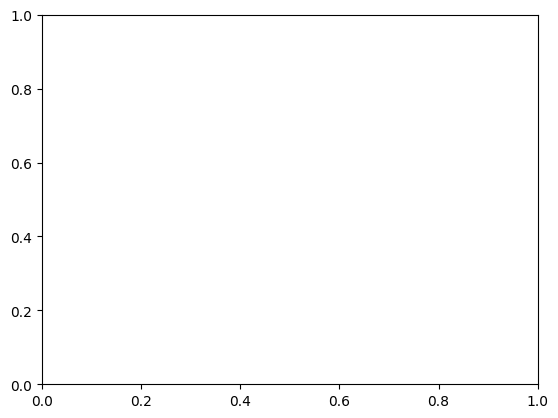

In [148]:
train_sessions

max_value = train_sessions['session_id'].max()

train_sessions['session_id'].hist(bins=max_value, color='skyblue', edgecolor='black')
plt.title('Feature Distribution')
plt.xlabel('ID')
plt.ylabel('Frequency')
#plt.grid(False)  # Disable the grid if preferred
plt.show()